In [1]:
import pandas as pd

In [4]:
path = "/home/juanbetancur/analisis_datos_universidad/evento_evaluativo_4/ejercicio_3/amazon_review_lemmatized.parquet"
df = pd.read_parquet(path, engine="pyarrow")
df.head()

,rating,clean_title,clean_review,clean_review_stemming,clean_review_lemmatization
0,3,more like funchuck,gave this to my dad for a gag gift after direc...,gave dad gag gift direct nunsens got reall kick,give dad gag gift direct nunsense get reall kick
1,5,inspiring,i hope a lot of people hear this cd we need mo...,hope lot peopl hear cd need strong posit vibe ...,hope lot people hear cd need strong positive v...
2,5,the best soundtrack ever to anything,im reading a lot of reviews saying that this i...,im read lot review say best game soundtrack fi...,read lot review say good game soundtrack figur...
3,4,chrono cross ost,the music of yasunori misuda is without questi...,music yasunori misuda without question close s...,music yasunori misuda without question close s...
4,5,too good to be true,probably the greatest soundtrack in history us...,probabl greatest soundtrack histori usual bett...,probably great soundtrack history usually well...


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
df['clase'] = df['rating'].apply(lambda x: 0 if x <= 2 else 1)


In [6]:
sample_size = 5000  # Ajusta según tu memoria RAM
df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)

print(f"Muestra tomada: {len(df_sample)} reviews")
print(f"Distribución - Clase 0: {sum(df_sample['clase']==0)}, Clase 1: {sum(df_sample['clase']==1)}")


Muestra tomada: 5000 reviews
Distribución - Clase 0: 1965, Clase 1: 3035


In [9]:
df_sample.head(3)

,rating,clean_title,clean_review,clean_review_stemming,clean_review_lemmatization,clase
736486,4,solid product some flaws,this is my fm transmitter for an ipod the ken...,fm transmitt ipod kensington digit fm transmit...,fm transmitter ipod kensington digital fm tran...,1
682037,2,good textbook horrible binding,it is what it is if your music program uses th...,music program use book serv function plenti si...,music program use book serve function plenty s...,0
2166228,2,uncomfortable,i work retail and spend a minimum of hours on...,work retail spend minimum hour feet daili end ...,work retail spend minimum hour foot daily en...,0


In [10]:
vectorizer = TfidfVectorizer(
    max_features=1000,      # Top 1000 palabras más importantes
    min_df=5,               # Palabra debe aparecer en al menos 5 docs
    max_df=0.8,             # Ignorar palabras en más del 80% de docs
    ngram_range=(1, 2),     # Unigramas y bigramas
    stop_words='english'    # Cambiar a 'spanish' si es necesario
)

X_tfidf = vectorizer.fit_transform(df_sample['clean_review_lemmatization'])
print(f"Matriz TF-IDF: {X_tfidf.shape}")


Matriz TF-IDF: (5000, 1000)


In [17]:
print("Aplicando t-SNE (esto puede tomar varios minutos)...")

tsne = TSNE(
    n_components=2,         # 2D para visualización
    perplexity=30,          # Balance local/global (probar 5-50)
    learning_rate=200,      # Velocidad de optimización
    max_iter=1000,            # Iteraciones
    random_state=42,
    verbose=1               # Mostrar progreso
)

# Convertir matriz dispersa a densa (t-SNE lo requiere)
X_dense = X_tfidf.toarray()
X_tsne = tsne.fit_transform(X_dense)

print("t-SNE completado!")

Aplicando t-SNE (esto puede tomar varios minutos)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.004s...
[t-SNE] Computed neighbors for 5000 samples in 1.077s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.375255
[t-SNE] KL divergence after 250 iterations with early exaggeration: 132.409363
[t-SNE] KL divergence after 1000 iterations: 3.841098
t-SNE completado!


In [18]:
df_tsne = pd.DataFrame({
    'x': X_tsne[:, 0],
    'y': X_tsne[:, 1],
    'clase': df_sample['clase'].values,
    'rating': df_sample['rating'].values
})


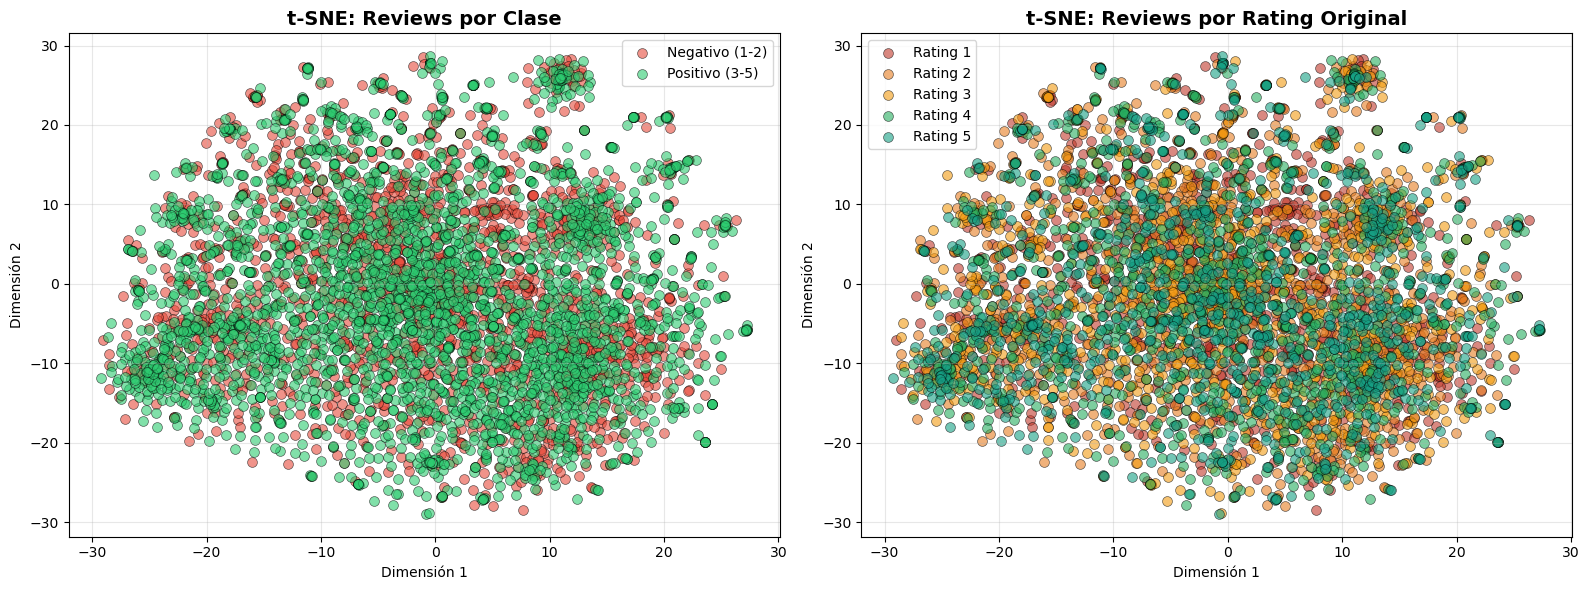

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Por clase (0 vs 1)
colors_clase = {0: '#e74c3c', 1: '#2ecc71'}
labels_clase = {0: 'Negativo (1-2)', 1: 'Positivo (3-5)'}

for clase in [0, 1]:
    mask = df_tsne['clase'] == clase
    axes[0].scatter(
        df_tsne[mask]['x'], 
        df_tsne[mask]['y'],
        c=colors_clase[clase],
        label=labels_clase[clase],
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

axes[0].set_title('t-SNE: Reviews por Clase', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Dimensión 1')
axes[0].set_ylabel('Dimensión 2')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Gráfico 2: Por rating original (1-5)
colors_rating = {1: '#c0392b', 2: '#e67e22', 3: '#f39c12', 4: '#27ae60', 5: '#16a085'}

for rating in sorted(df_tsne['rating'].unique()):
    mask = df_tsne['rating'] == rating
    axes[1].scatter(
        df_tsne[mask]['x'], 
        df_tsne[mask]['y'],
        c=colors_rating[rating],
        label=f'Rating {rating}',
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

axes[1].set_title('t-SNE: Reviews por Rating Original', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Dimensión 1')
axes[1].set_ylabel('Dimensión 2')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('tsne_reviews.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
from scipy.spatial.distance import cdist

# Calcular centroides de cada clase
centroid_0 = df_tsne[df_tsne['clase']==0][['x', 'y']].mean()
centroid_1 = df_tsne[df_tsne['clase']==1][['x', 'y']].mean()

# Distancia entre centroides
distance = np.sqrt((centroid_0['x'] - centroid_1['x'])**2 + 
                   (centroid_0['y'] - centroid_1['y'])**2)

print("\n" + "="*50)
print("ANÁLISIS DE SEPARABILIDAD")
print("="*50)
print(f"Centroide Clase 0: ({centroid_0['x']:.2f}, {centroid_0['y']:.2f})")
print(f"Centroide Clase 1: ({centroid_1['x']:.2f}, {centroid_1['y']:.2f})")
print(f"Distancia entre centroides: {distance:.2f}")
print("\nInterpretación:")
if distance > 20:
    print("✅ Las clases están bien separadas (fácil de clasificar)")
elif distance > 10:
    print("⚠️ Las clases tienen separación moderada")
else:
    print("❌ Las clases se superponen mucho (difícil de clasificar)")



ANÁLISIS DE SEPARABILIDAD
Centroide Clase 0: (-0.66, 0.78)
Centroide Clase 1: (-0.72, -1.56)
Distancia entre centroides: 2.34

Interpretación:
❌ Las clases se superponen mucho (difícil de clasificar)


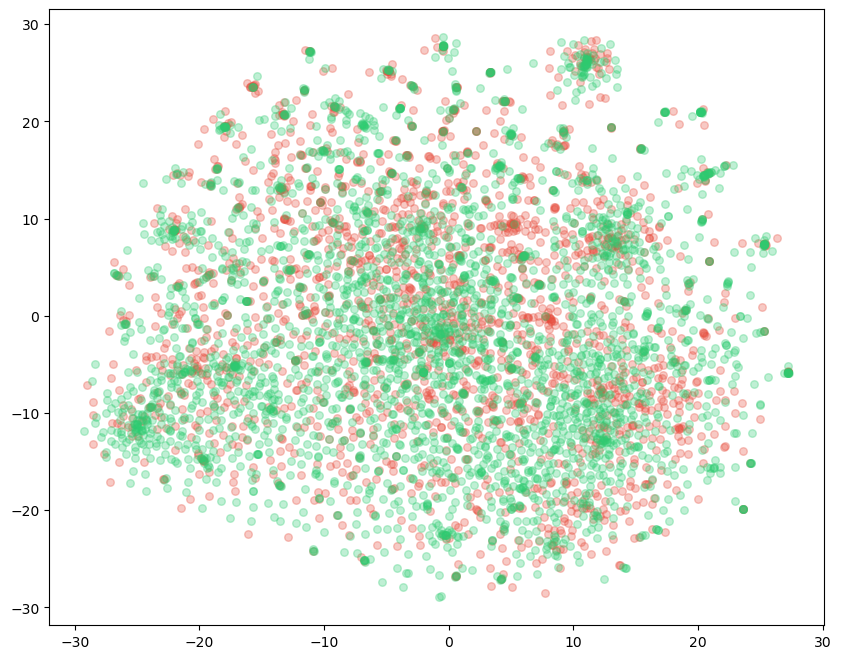

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))

for clase in [0, 1]:
    mask = df_tsne['clase'] == clase
    ax.scatter(
        df_tsne[mask]['x'], 
        df_tsne[mask]['y'],
        c=colors_clase[clase],
        label=labels_clase[clase],
        alpha=0.3,
        s=30
    )

In [25]:
from scipy.stats import gaussian_kde

for clase in [0, 1]:
    mask = df_tsne['clase'] == clase
    xy = df_tsne[mask][['x', 'y']].values.T
    
    if len(xy[0]) > 10:  # Solo si hay suficientes puntos
        kde = gaussian_kde(xy)
        
        # Crear grid
        x_min, x_max = df_tsne['x'].min(), df_tsne['x'].max()
        y_min, y_max = df_tsne['y'].min(), df_tsne['y'].max()
        xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        
        # Calcular densidad
        density = kde(positions).reshape(xx.shape)
        
        # Dibujar contornos
        ax.contour(xx, yy, density, colors=colors_clase[clase], alpha=0.5, linewidths=2)

ax.set_title('t-SNE con Densidad de Clusters', fontsize=14, fontweight='bold')
ax.set_xlabel('Dimensión 1')
ax.set_ylabel('Dimensión 2')
ax.legend()
ax.grid(alpha=0.3)

plt.show()

In [26]:
# Filtrar antes de entrenar
df_filtered = df[df['rating'] != 3].copy()
df_filtered['clase'] = df_filtered['rating'].apply(lambda x: 0 if x <= 2 else 1)

print(f"Original: {len(df)} reviews")
print(f"Filtrado: {len(df_filtered)} reviews")
print(f"Reviews eliminadas: {len(df) - len(df_filtered)}")

# Ahora entrena con df_filtered y ejecuta t-SNE de nuevo

Original: 3629444 reviews
Filtrado: 2903016 reviews
Reviews eliminadas: 726428
